In [1]:
import matplotlib.pyplot as plt
all_samples_path = '/data/at3/scratch3/jharrison/nominal_feather/Regions'

region_file = 'CR_1Z_0b_2SFOS.ftr'

#Set training hyperparameters
model_type = 'AE'
batch_size = 1024
learning_rate = 1e-2
num_epochs = 30
Train = True
load_path = 'outputs/VAE_1943-16-08-2022/model_state_dict.pt'
test_dump = False
size= -1


#Preprocessing settings
remove_zero_weights = True
remove_negative_weights = True
weight_loss = True
added_weight_factor = 500

#Test settings
validation_groups = ['VV', 'Top', 'VH', 'VVV']
validation_fraction = 0.1
test_fraction = 0.2
val_frequency = 2
num_test_samples = -1
evaluate_signals = True

additional_comments = """
AE:
Testing separations.
Using best mZ to start.
"""

# Get Data

In [2]:
all = "XXX_singleTop_schan_samples, XXX_singleTop_tchan_samples, XXX_tW_samples, XXX_Zjets_samples, XXX_Wjets_samples, XXX_Vgamma_samples, XXX_ttW2210_EW_samples, XXX_ttH_samples, XXX_ttZalt_samples, XXX_rareTop_samples, XXX_VV_samples, XXX_threeTop_samples, XXX_fourTop_samples, XXX_ttWW_samples, XXX_tZ_samples, XXX_WtZ_samples, XXX_VVV_samples, XXX_VH_samples,XXX_tHjb_samples,XXX_ttbar_nonallhad_samples,XXX_ttZZ_samples,XXX_ttWH_samples,XXX_ttHH_samples"

samples = all.split(',')
sample_names = [s.split('_')[1] for s in samples]
sample_names

['singleTop',
 'singleTop',
 'tW',
 'Zjets',
 'Wjets',
 'Vgamma',
 'ttW2210',
 'ttH',
 'ttZalt',
 'rareTop',
 'VV',
 'threeTop',
 'fourTop',
 'ttWW',
 'tZ',
 'WtZ',
 'VVV',
 'VH',
 'tHjb',
 'ttbar',
 'ttZZ',
 'ttWH',
 'ttHH']

In [3]:
import pandas as pd
import os

data = pd.read_feather(os.path.join(all_samples_path, region_file))

#chosen_samples = ['ggVV', 'singleTop', 'tW', 'Zjets', 'Wjets', 'Vgamma', 'ttW2210', 'ttH', 'ttZalt', 'rareTop', 'VV', 
#                  'threeTop', 'fourTop', 'ttWW',
#                  'tZ', 'WtZ', 'VVV', 'VH', 'tHjb', 'ttbar', 'ttZZ', 'ttWH', 'ttHH']

chosen_samples =['singleTop',
 'tW',
 'Zjets',
 'Wjets',
 'Vgamma',
 'ttW2210',
 'ttH',
 'ttZalt',
 'rareTop',
 'VV',
 'ggVV',
 'threeTop',
 'fourTop',
 'ttWW',
 'tZ',
 'WtZ',
 'VVV',
 'VH',
 'tHjb',
 'ttbar',
 'ttZZ',
 'ttWH',
 'ttHH']

groupings = {
    'VV' : ['ggVV','VV'],
    'VVV': ['VVV'],
    'VH' : ['VH'],
    'Top': ['ttZalt', 'fourTop', 'ttWW','ttH','WtZ'],
    'Other' : ['singleTop','tW','Zjets','Wjets','Vgamma','ttW2210','rareTop','threeTop','tZ','tHjb','ttbar','ttZZ','ttWH','ttHH']
}
reversed_groupings = {}
for key, values in groupings.items():
    for val in values:
        reversed_groupings[val] = key

training_variables = [
#    'lep_Pt_0',
#    'lep_Pt_1',
#    'lep_Pt_2',
#    'lep_Pt_3',
#    'lep_Eta_0',
#    'lep_Eta_1',
#    'lep_Eta_2',
#    'lep_Eta_3',
#    'lep_Phi_0',
#    'lep_Phi_1',
#    'lep_Phi_2',
#    #'lep_Phi_3',
    'met_met',
#    'met_phi',
    'Mllll0123',
    'HT_lep',
    'HT_jets',
    'nJets_OR',
    'sumPsbtag',
    'weight',
    'sample',
    'Mll01',
    'Mll02',
    'Mll03',
    'Mll12',
    'Mll13',
    'Mll23'
]
get_bestZ = True
#We will want Mll of SFOS ? 

mc_data = data.loc[data['sample'].isin(chosen_samples)]

# Calculate weight

In [4]:
total_lum = 138965.16
mc_data.loc[mc_data['RunYear'].isin([2015,2016]), 'lumi_scale'] = 36207.66*(1/total_lum)
mc_data.loc[mc_data['RunYear'].isin([2017]), 'lumi_scale'] = 44307.4*(1/total_lum)
mc_data.loc[mc_data['RunYear'].isin([2018]), 'lumi_scale'] = 58450.1*(1/total_lum)

mc_data['weight'] = mc_data['lumi_scale']*mc_data['custTrigSF_TightElMediumMuID_FCLooseIso_DLT']*mc_data['weight_pileup']*mc_data['jvtSF_customOR']*mc_data['bTagSF_weight_DL1r_77']*mc_data['weight_mc']*mc_data['xs']*mc_data['lep_SF_CombinedLoose_0']*mc_data['lep_SF_CombinedLoose_1']*mc_data['lep_SF_CombinedLoose_2']*mc_data['lep_SF_CombinedLoose_3']/mc_data['totalEventsWeighted']

#mc_data.loc[:,'weight'] = mc_data.loc[:,'lumi_scale']*mc_data.loc[:,'custTrigSF_TightElMediumMuID_FCLooseIso_DLT']*mc_data.loc[:,'weight_pileup']*mc_data.loc[:,'jvtSF_customOR']*mc_data.loc[:,'bTagSF_weight_DL1r_77']*mc_data.loc[:,'weight_mc']*mc_data.loc[:,'xs']*mc_data.loc[:,'lep_SF_CombinedLoose_0']*mc_data.loc[:,'lep_SF_CombinedLoose_1']*mc_data.loc[:,'lep_SF_CombinedLoose_2']*mc_data.loc[:,'lep_SF_CombinedLoose_3']/mc_data.loc[:,'totalEventsWeighted']


/tmp/ipykernel_626/2084566788.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_data.loc[mc_data['RunYear'].isin([2015,2016]), 'lumi_scale'] = 36207.66*(1/total_lum)
/tmp/ipykernel_626/2084566788.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_data['weight'] = mc_data['lumi_scale']*mc_data['custTrigSF_TightElMediumMuID_FCLooseIso_DLT']*mc_data['weight_pileup']*mc_data['jvtSF_customOR']*mc_data['bTagSF_weight_DL1r_77']*mc_data['weight_mc']*mc_data['xs']*mc_data['lep_SF_CombinedLoose_0']*mc_data['

In [5]:
mc_data = mc_data[training_variables]

# Run over small sample set

In [6]:
if size != -1:
    mc_data = mc_data[:size]

# Remove negative weights

In [7]:
num_zero_weights = len(mc_data.loc[mc_data['weight']==0])
num_negative_weights = len(mc_data.loc[mc_data['weight']<0])

print(f"Zero weights: {num_zero_weights} , Negative weights: {num_negative_weights}")

Zero weights: 4255 , Negative weights: 103032


In [8]:
#Remove 0 weights
if remove_zero_weights:
    mc_data = mc_data.loc[mc_data['weight']!=0]
if remove_negative_weights:
    mc_data = mc_data.loc[mc_data['weight']>=0]

In [9]:
#Check for nulls
for col in mc_data.columns:
    nulls = mc_data[col].isnull().sum()
    if nulls != 0:
        print(col, nulls)

In [10]:
# Check for duplicate rows
before = len(mc_data)
mc_data = mc_data.drop_duplicates()
print(f"Before: {before}, After: {len(mc_data)}")

Before: 1198420, After: 1198416


# Calculate the best mZll

In [11]:
def get_Zll_pairing(df, drop_Mlls=False):
    
    pairings=  {
        'Mll01' : 'Mll23', 
        'Mll02':'Mll13',
        'Mll03':'Mll12',
        'Mll12':'Mll03',
        'Mll13':'Mll02',
        'Mll23':'Mll01'
         }
    mll_columns = list(pairings.keys())
    if mll_columns[0] not in df.columns:
        print("Not found the required Mll columns... Returning the original dataframe.")
        return df
    df['bestZpair'] = (abs(df[mll_columns]-91.3e3)).idxmin(axis=1)
    df['otherZ'] = df['bestZpair'].map(pairings)
    df = df.reset_index(drop=True)
    df['best_mZll'] = [df.loc[i,col] for i, col in enumerate(df['bestZpair'])]
    df['other_mZll'] = [df.loc[i,col] for i, col in enumerate(df['otherZ'])]
    
    df.drop(['bestZpair','otherZ'], axis=1,inplace=True)
    if drop_Mlls:
        df.drop(mll_columns,axis=1,inplace=True)
    return df

if get_bestZ:
    mc_data = get_Zll_pairing(mc_data, drop_Mlls=True)

# Scaling features

In [12]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scalers = {}

for col in mc_data.columns:
    
    scaler = StandardScaler()
    if col == 'weight':
        #Scale the weights to be centered on 1
        mc_data.loc[:,'scaled_weight'] = mc_data.loc[:,col]/mc_data[col].sum()
        continue
        
    if col == 'sample':
        continue
        
    mc_data.loc[:, col] = scaler.fit_transform(np.array(mc_data[col]).reshape(len(mc_data[col]),1))
    print(col, mc_data[col].mean())
    scalers[col] = scaler

met_met 3.6685916682531127e-09
Mllll0123 6.193584112918889e-09
HT_lep -7.1421218005307426e-09
HT_jets 1.4735782434994492e-08
nJets_OR 8.980871364788417e-13
sumPsbtag -1.1428919048280114e-12
best_mZll 5.259079259284297e-10
other_mZll 3.352277717138632e-10


# Train / Test split

In [13]:
#train, test = train_test_split(mc_data, test_size=validation_fraction, stratify=mc_data['sample'])

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
all_val_data = pd.DataFrame()
print("Length of mc_data: ", len(mc_data))
for sample in chosen_samples:
    sample_data = mc_data.loc[mc_data['sample'] == sample]
    if len(sample_data) == 0:
        continue
    if len(sample_data)*validation_fraction < 1:
        continue
    train_data, test_data = train_test_split(sample_data, test_size=validation_fraction)
    all_val_data = pd.concat([all_val_data, test_data])

    mc_data.drop(index=test_data.index.values, axis=0,inplace=True)
    print(sample, len(test_data))
        
print("Removed: ", len(all_val_data))
print("Remaining length: ", len(mc_data))

Length of mc_data:  1198416
Zjets 2
ttH 39
ttZalt 424
VV 82941
ggVV 32767
tZ 2
WtZ 35
VVV 3633
VH 2
Removed:  119845
Remaining length:  1078571


In [15]:
all_test_data = pd.DataFrame()
print("Length of mc_data: ", len(mc_data))
for g in validation_groups:
    for sample in groupings[g]:
        sample_data = mc_data.loc[mc_data['sample'] == sample]
        if len(sample_data) == 0:
            continue
        if len(sample_data)*validation_fraction < 1:
            continue
        train_data, test_data = train_test_split(sample_data, test_size=test_fraction)
        all_test_data = pd.concat([all_test_data, test_data])

        mc_data.drop(index=test_data.index.values, axis=0,inplace=True)
        print(sample, len(test_data))
        
print("Removed: ", len(all_test_data))
print("Remaining length: ", len(mc_data))

Length of mc_data:  1078571
ggVV 58979
VV 149294
ttZalt 762
ttH 69
WtZ 63
VH 3
VVV 6539
Removed:  215709
Remaining length:  862862


# VAE DEFINITION

In [16]:
from model.autoencoder import VAE, AE

useful_columns = [col for col in mc_data.columns if col not in ['sample','weight', 'scaled_weight']]

enc_dim = [len(useful_columns),4]
dec_dim = [4,len(useful_columns)]
z_dim = 2

if model_type == 'AE':
    model = AE(enc_dim, dec_dim, z_dim)
elif model_type == 'VAE':
    model = VAE(enc_dim, dec_dim, z_dim)

/data/at3/scratch3/jharrison/miniconda3/envs/ML_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loss Function

In [17]:
# return reconstruction error + KL divergence losses
import torch.nn.functional as F

def loss_function(recon_x, x, mu, log_var, variational=True):
    #BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    MSE = F.mse_loss(x, recon_x, reduction='none')   #Works it out element-wise
    MSE = torch.mean(MSE, dim=1)   #Average across featuers, leaving per-example MSE
    
    if variational:
        KLD = 1 + log_var - mu.pow(2) - log_var.exp()   #Again worked out element-wise
        KLD = -0.5 * torch.sum(KLD, dim=1)   #Sum across features, leaving per-example KLD
        return MSE + KLD, MSE, KLD
    else:
        return MSE, None, None


# Training

In [18]:
#Train on GPU if possible 

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using available: {device}")
device = 'cpu'
model = model.to(device)

Using available: cpu


In [19]:
print(f"Number of batches per epoch: {len(mc_data) / batch_size}")

Number of batches per epoch: 842.638671875


# Optimizer

In [20]:
import torch.optim as optim

#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Dataset

In [21]:
# importing the required libraries
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
  
# Dataset class, needs to be built from pandas dataframe
class data_set(Dataset):
    
    def __init__(self, dataset):
        
        self.weights = None
        self.samples = None
        self.scaled_weights  = None
        
        if 'weight' in dataset.columns:
            self.weights = torch.tensor(dataset['weight'].values, dtype=torch.float32)
            dataset.drop('weight', axis=1, inplace=True)
            
        if 'scaled_weight' in dataset.columns:
            self.scaled_weights = torch.tensor(dataset['scaled_weight'].values, dtype=torch.float32)
            dataset.drop('scaled_weight', axis=1, inplace=True)
            
        if 'sample' in dataset.columns:
            self.samples = dataset['sample']
            dataset.drop('sample', axis=1, inplace=True)
        
        self.data = torch.tensor(dataset.values, dtype=torch.float32)
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, index):
        
        #weights =  self.weights[index] if self.weights!=None else None
        #samples =  [] if self.samples == None else self.samples[index]
        #TODO: ADD CHECKING FOR IF NO WEIGHTS OR SAMPLES ARE PASSED
        sc_weight = self.scaled_weights[index] if self.scaled_weights != None else None
        return self.data[index], self.weights[index], self.samples.iloc[index], sc_weight


In [22]:
dataset = data_set(mc_data)
val_set = data_set(all_val_data)
test_set = data_set(all_test_data)
  
# implementing dataloader on the dataset and printing per batch
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_set, batch_size=1)
testloader = DataLoader(test_set, batch_size=1)

In [23]:
import numpy as np
from tqdm import tqdm   #TODO: Install widgets for notebook version


stored_batches = []
batch_losses = []
epoch_losses = []
validation_losses = []
if Train:
    for epoch in range(num_epochs):
        av_epoch_loss = 0
        nbatches = 0
        model.train()
        for idx, (data, weights, samples, sc_weight) in tqdm(enumerate(dataloader, 0)):

            data = data.to(device)
            #weights = weights.to(device)
            sc_weight = sc_weight.to(device)

            optimizer.zero_grad()

            # Feeding a batch of images into the network to obtain the output image, mu, and logVar
            out, mu, logVar = model(data)
            loss, mse, kld = loss_function(out, data, mu, logVar, variational=model.variational)

            #Multiply the loss by the weights
            if weight_loss:
                loss = torch.dot(added_weight_factor*sc_weight, loss)
            else:
                loss = torch.sum(loss)

            # Backpropagation based on the loss
            loss.backward()
            optimizer.step()
            av_epoch_loss += loss.item()
            nbatches += 1
            if idx % 5000 == 0:
                batch_losses.append(loss.item())
            
        av_epoch_loss = av_epoch_loss/nbatches
        epoch_losses.append(av_epoch_loss)
        if epoch % 2 == 0:
            print('Epoch {}: Loss {}'.format(epoch, av_epoch_loss))
            
        #Do a per-sample validation loss
        if epoch % val_frequency == 0:
            model.eval()
            val_losses = {}
            val_counts = {}
            for idy, (data, weights, samples, sc_weights) in enumerate(valloader, 0):
                samples=samples[0]
                out, mu, logVar = model(data)
                loss, mse, kld = loss_function(out, data, mu, logVar, variational=model.variational)
                #Multiply the loss by the weights
                if weight_loss:
                    loss = torch.dot(added_weight_factor*sc_weights, loss)
                else:
                    loss = torch.sum(loss)
                running_sum = val_losses.get(reversed_groupings[samples],0)
                running_counts = val_losses.get(reversed_groupings[samples],0)
                running_counts += 1
                running_sum += loss.item()
                val_losses[reversed_groupings[samples]] = running_sum
                val_counts[reversed_groupings[samples]] = running_counts
            #av_val_loss = val_loss/(idy+1)
            for key in val_counts.keys():
                val_losses[key] = val_losses[key]/val_counts[key]
            validation_losses.append(val_losses)
            print('Epoch {}: Validation Loss {}'.format(epoch, val_losses))
        #Add an early stopping?

843it [01:49,  7.72it/s]


Epoch 0: Loss 0.35249731103720616
Epoch 0: Validation Loss {'Other': 0.023204726370779402, 'Top': 0.5911590048402511, 'VV': 0.9729267812546296, 'VVV': 0.47684823909992086, 'VH': 0.09614027647054703}


843it [01:50,  7.65it/s]
843it [01:49,  7.68it/s]


Epoch 2: Loss 0.28171597490107037
Epoch 2: Validation Loss {'Other': 0.021365068812882346, 'Top': 0.5681547991445699, 'VV': 0.9682512598176988, 'VVV': 0.4621732608424358, 'VH': 0.07950060270553536}


843it [01:47,  7.86it/s]
843it [01:49,  7.72it/s]


Epoch 4: Loss 0.24179260522869558
Epoch 4: Validation Loss {'Other': 0.019298894032604978, 'Top': 0.540593426852669, 'VV': 0.9635711171132515, 'VVV': 0.4437792764593422, 'VH': 0.062387697391092636}


843it [01:47,  7.87it/s]
843it [01:46,  7.93it/s]


Epoch 6: Loss 0.21166006492479558
Epoch 6: Validation Loss {'Other': 0.018885780621554243, 'Top': 0.5214433337132095, 'VV': 0.95917894548057, 'VVV': 0.4301326096444, 'VH': 0.04953536071083178}


843it [01:47,  7.86it/s]
843it [01:47,  7.83it/s]


Epoch 8: Loss 0.1979477284907022
Epoch 8: Validation Loss {'Other': 0.018950389861408023, 'Top': 0.5097732757228447, 'VV': 0.9572424252936568, 'VVV': 0.42333371576686885, 'VH': 0.048609646177421126}


843it [01:48,  7.77it/s]
843it [01:48,  7.78it/s]


Epoch 10: Loss 0.1918074838896663
Epoch 10: Validation Loss {'Other': 0.018933389799439225, 'Top': 0.5017076333139394, 'VV': 0.956170328181561, 'VVV': 0.4185203791690506, 'VH': 0.050526387587892393}


843it [01:50,  7.65it/s]
843it [01:50,  7.63it/s]


Epoch 12: Loss 0.18734019291217074
Epoch 12: Validation Loss {'Other': 0.0189841787365403, 'Top': 0.49511850739742785, 'VV': 0.9553075613512951, 'VVV': 0.4142257988887881, 'VH': 0.05248338323971636}


843it [01:50,  7.65it/s]
843it [01:50,  7.60it/s]


Epoch 14: Loss 0.18374527735394797
Epoch 14: Validation Loss {'Other': 0.019146365463261778, 'Top': 0.48973718880129546, 'VV': 0.9545972985940719, 'VVV': 0.41057147847728104, 'VH': 0.05433697816654533}


843it [01:49,  7.71it/s]
843it [01:49,  7.73it/s]


Epoch 16: Loss 0.18082068422157427
Epoch 16: Validation Loss {'Other': 0.01933067978285701, 'Top': 0.48520905926376856, 'VV': 0.9539903355741319, 'VVV': 0.40730169480602174, 'VH': 0.055799541805104776}


843it [01:50,  7.60it/s]
843it [01:50,  7.63it/s]


Epoch 18: Loss 0.17841859366899424
Epoch 18: Validation Loss {'Other': 0.01952131299508443, 'Top': 0.48149013398867185, 'VV': 0.9534881655399297, 'VVV': 0.40448046567951673, 'VH': 0.05698771569023823}


843it [01:52,  7.50it/s]
843it [01:49,  7.72it/s]


Epoch 20: Loss 0.17642349404230945
Epoch 20: Validation Loss {'Other': 0.019692859564346826, 'Top': 0.4783615050487105, 'VV': 0.9530696718220979, 'VVV': 0.402002887157607, 'VH': 0.05799014874239621}


843it [01:52,  7.50it/s]
843it [01:52,  7.47it/s]


Epoch 22: Loss 0.17474307247116047
Epoch 22: Validation Loss {'Other': 0.019831467860434722, 'Top': 0.47569095243416093, 'VV': 0.9527160385287381, 'VVV': 0.39977942303920766, 'VH': 0.058778469449435905}


843it [01:50,  7.64it/s]
843it [01:48,  7.75it/s]


Epoch 24: Loss 0.17330821586744075
Epoch 24: Validation Loss {'Other': 0.019948606351692186, 'Top': 0.4734139983354748, 'VV': 0.9524103165902509, 'VVV': 0.39784035661415645, 'VH': 0.05939500245973697}


843it [01:49,  7.67it/s]
843it [01:48,  7.78it/s]


Epoch 26: Loss 0.17206508785592278
Epoch 26: Validation Loss {'Other': 0.02003015227127542, 'Top': 0.471408593174885, 'VV': 0.9521437427524049, 'VVV': 0.3961110153892909, 'VH': 0.05998539711590908}


843it [01:46,  7.88it/s]
843it [01:48,  7.76it/s]


Epoch 28: Loss 0.1709744879094307
Epoch 28: Validation Loss {'Other': 0.020093008380654705, 'Top': 0.46964782315198594, 'VV': 0.9519085018114206, 'VVV': 0.39456110279596973, 'VH': 0.06049964781662374}


843it [01:49,  7.73it/s]


In [24]:
import os
import datetime as dt


date = dt.datetime.strftime(dt.datetime.now(),"%H%M-%d-%m-%Y")
output_dir = 'outputs/VAE_'+date
if test_dump:
    output_dir = 'outputs/test_dump'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
Description = f"""Training run: {Train}
Model variational: {model.variational}
Samples used: {chosen_samples}
Features used: {training_variables}
Number of examples: {len(mc_data)}
Weighted loss: {weight_loss}
Added weight factor: {added_weight_factor}
Learning rate: {learning_rate}
Num epochs: {num_epochs}
Batch size: {batch_size}
Region: {region_file}
Number of test samples: {num_test_samples}
Validation fraction: {validation_fraction} - {len(all_val_data)} events.
Test fraction: {test_fraction} - {len(all_test_data)} events.

Model architecture:
{model}

Optimizer:
{optimizer}

Additional comments: 
{additional_comments}
"""
with open(os.path.join(output_dir, 'description.txt'),'w') as f:
    f.writelines(Description)


In [25]:
#Save the model and optimizer
if Train:
    torch.save(model.state_dict(), os.path.join(output_dir, 'model_state_dict.pt'))
    torch.save(optimizer.state_dict(), os.path.join(output_dir, 'optimizer_state_dict.pt'))

In [26]:
import pickle

In [27]:
#Save the scalers used for each column
scaler_folder = os.path.join(output_dir, 'scalers')
if not os.path.exists(scaler_folder):
    os.makedirs(scaler_folder)
    
import pickle
for col, sc in scalers.items():
    pickle.dump(sc, open(os.path.join(scaler_folder,col+'_scaler.pkl'),'wb'))
    
#sc = pickle.load(open('file/path/scaler.pkl','rb'))

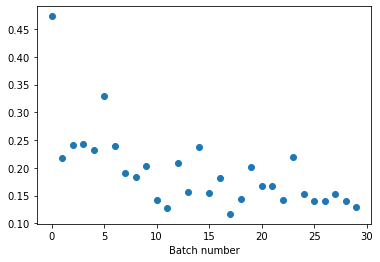

In [28]:
import matplotlib.pyplot as plt
if Train:
    with torch.no_grad():
        plt.scatter([i for i in range(len(batch_losses))], batch_losses)
        plt.xlabel('Batch number')
        plt.ylabel
        ('Batch Loss')
        plt.savefig(os.path.join(output_dir, 'Batch_losses.png'))
        plt.show()

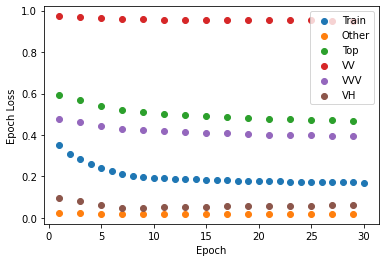

In [29]:
import matplotlib.pyplot as plt
if Train:
    with torch.no_grad():
        plt.scatter([i+1 for i in range(len(epoch_losses))], epoch_losses, label='Train')
        #plt.scatter([val_frequency*i for i in range(len(validation_losses))], validation_losses, label='Val')
        #plot validation per sample
        for key in validation_losses[0].keys():
            plt.scatter([val_frequency*i+1 for i in range(len(validation_losses))], [v[key] for v in validation_losses], label=key)
        plt.xlabel('Epoch')
        plt.ylabel('Epoch Loss')
        plt.legend()
        plt.savefig(os.path.join(output_dir, 'Epoch_losses.png'))
        plt.show()

# Set up tracking of training runs

## Items to save:

Hyperparameters
Model architecture 
Saved model ?
Loss plots

# Start plotting the Anomaly scores:

In [30]:
if not Train:
    
    #Load the model:
    model.load_state_dict(torch.load(load_path))

In [31]:

# implementing dataloader on the dataset and printing per batch
test_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# evaluate model:
model.eval()

test_output = {
    'input' : [],
    'output' : [],
    'mu' : [],
    'loss' : [],
    'samples' : [],
    'groups' : [],
    'weights' : [],
    'log_losses' : []
}

from tqdm import tqdm
import math 

with torch.no_grad():
    for idx, (data, weights, sample, sc_weight) in tqdm(enumerate(test_loader, 0)):

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = model(data)
        loss, mse, kld = loss_function(out, data, mu, logVar, variational=model.variational)
        
        test_output['input'].append(data)
        test_output['output'].append(out)
        test_output['mu'].append(mu.tolist())
        test_output['loss'].append(loss.item())
        test_output['samples'].append(sample[0])
        test_output['weights'].append(weights.item())
        test_output['log_losses'].append(math.log(loss.item()))
        test_output['groups'].append(reversed_groupings[sample[0]])
        
        if idx > num_test_samples and num_test_samples != -1:
            break
        
test_output['loss'] = np.array(test_output['loss'])
test_output['log_losses'] = np.array(test_output['log_losses'])

862862it [10:27, 1375.64it/s]


In [32]:
#np.save('data/test_mus.npy', np.array(test_output['mu']))

# Analysis of results

In [33]:
def plot_hist(edges, counts, xlabel=None, ylabel=None, title=None, key=None, colour='b', fill=False, save_name=None):
    #fig = plt.bar(edges[:-1], counts, width=edges[1]-edges[0], label=key, fill=fill, color=colour, edgecolor=colour)
    plt.step(edges[:-1], counts, colour, label=key)
    #plt.stairs(counts, edges, color=colour, label=key)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    if save_name is not None:
        plt.savefig(save_name)
    

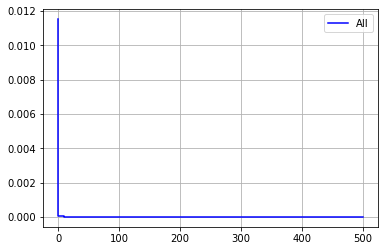

In [34]:
num_bins=50
loss_counts, loss_edges = np.histogram(test_output['loss'], bins=num_bins, weights=test_output['weights'])
plot_hist(loss_edges, loss_counts, key='All', save_name=os.path.join(output_dir, 'Anomaly_score_hist_All.png'))

In [35]:
'''
num_bins = 50
import matplotlib.pyplot as plt
plt.hist(test_output['log_losses'], bins=num_bins, label='All', weights=test_output['weights'],histtype='step')
plt.xlabel('Log loss')
plt.ylabel('Counts')
plt.legend()
plt.savefig(os.path.join(output_dir, 'Log_Ascore_All.png'))
plt.show()
'''

"\nnum_bins = 50\nimport matplotlib.pyplot as plt\nplt.hist(test_output['log_losses'], bins=num_bins, label='All', weights=test_output['weights'],histtype='step')\nplt.xlabel('Log loss')\nplt.ylabel('Counts')\nplt.legend()\nplt.savefig(os.path.join(output_dir, 'Log_Ascore_All.png'))\nplt.show()\n"

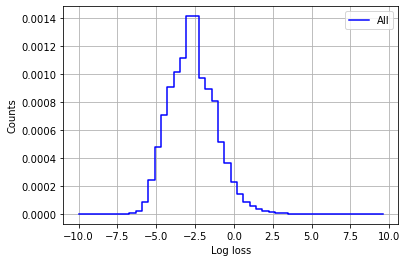

In [36]:
num_bins = 50
logloss_bins = np.linspace(-10,10,num=num_bins)

test_logloss_counts, test_logloss_edges = np.histogram(test_output['log_losses'], bins=logloss_bins, weights=test_output['weights'])
fig = plot_hist(test_logloss_edges, test_logloss_counts, xlabel='Log loss', ylabel='Counts', key='All', save_name=os.path.join(output_dir, 'Log_Ascore_All.png'))

In [37]:
def plot_hist_stack(edges, counts, xlabel=None, ylabel=None, title=None, labels=None, colours=None, fill=False, save_name=None):

    for i, (edge, count) in enumerate(zip(edges,counts)):
        #plt.bar(edge[:-1], count, width=edge[1]-edge[0], label=labels[i], fill=fill, edgecolor=colours[i])
        plt.step(edge[:-1], count, colours[i], label=labels[i] )
        #plt.stairs(count, edge, color=colours[i], label=labels[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    if save_name is not None:
        plt.savefig(save_name)
    return None

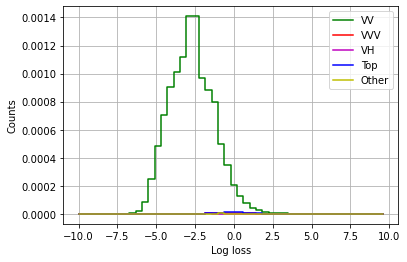

In [38]:
counts = []
edges = []
labels = []
colour_scheme = {'VV' : 'g', 'VVV' : 'r', 'VH' : 'm' , 'Top': 'b', 'Other' : 'y'}
colours = []
for group, samples in groupings.items():
    index = np.where(np.isin(test_output['samples'],samples))[0]
    weights = np.array(test_output['weights'])[index]
    loss_counts, loss_edges = np.histogram(test_output['log_losses'][index], bins=logloss_bins, weights=weights)
    counts.append(loss_counts)
    edges.append(loss_edges)
    labels.append(group)
    colours.append(colour_scheme[group])
    
fig = plot_hist_stack(edges, counts, xlabel='Log loss', ylabel='Counts', labels=labels, colours=colours)

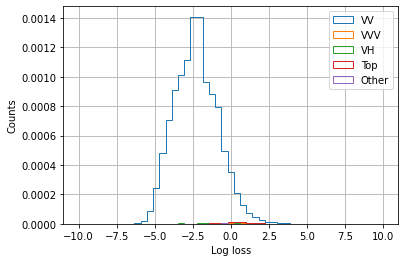

In [39]:
num_bins = 10
fig = plt.figure()
for group, samples in groupings.items():
    bar_heights = 0
    index = np.where(np.isin(test_output['samples'],samples))
    weights = np.array(test_output['weights'])[index]
    plt.hist(np.array(test_output['log_losses'])[index], bins=logloss_bins, label=group, weights=weights,histtype='step')
    
plt.xlabel('Log loss')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'Anomaly_score_hist_bySample.png'))
plt.show()

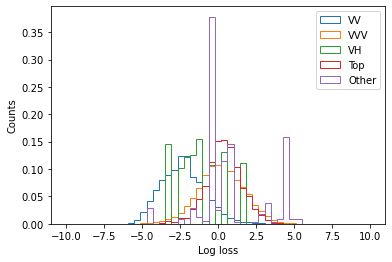

In [40]:

fig = plt.figure()

for group, samples in groupings.items():
    bar_heights = 0
    index = np.where(np.isin(test_output['samples'],samples))
    weights = np.array(test_output['weights'])[index] / np.sum(np.array(test_output['weights'])[index])
    plt.hist(np.array(test_output['log_losses'])[index], bins=logloss_bins, label=group, weights=weights,histtype='step')
    
plt.xlabel('Log loss')
plt.ylabel('Counts')
plt.legend()
plt.savefig(os.path.join(output_dir, 'Anomaly_score_hist_bySampleNormalised.png'))
plt.show()

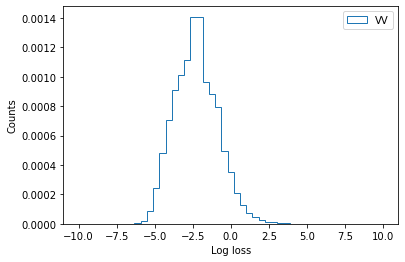

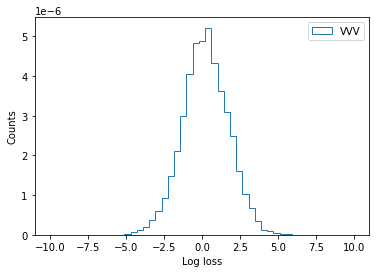

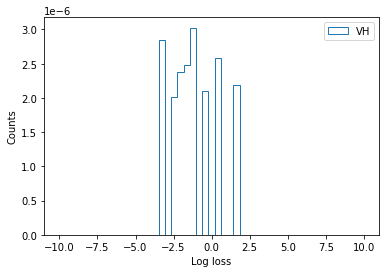

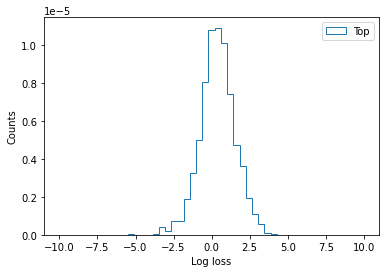

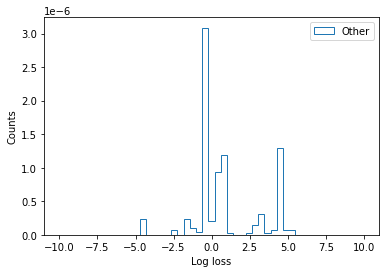

In [41]:
for group, samples in groupings.items():
    fig = plt.figure()
    bar_heights = 0
    index = np.where(np.isin(test_output['samples'],samples))
    weights = np.array(test_output['weights'])[index]
    plt.hist(np.array(test_output['log_losses'])[index], bins=logloss_bins, label=group, weights=weights,histtype='step')
    plt.xlabel('Log loss')
    plt.ylabel('Counts')
    plt.legend()
    plt.savefig(os.path.join(output_dir, f"Anomaly_score_hist_Sample{group}.png"))
    plt.show()

In [42]:
np.save(os.path.join(output_dir, 'test_mus.npy'), np.array(test_output['mu']))

In [43]:
'''
import matplotlib.pyplot as plt
import umap

def plot_umap(fit_data, targets=None,labs=None, neighbours=15, rand_state=None, title=None, colour="gist_rainbow",
              save_name=None):
    
    fit = umap.UMAP(random_state=rand_state, n_neighbors=neighbours)
    u = fit.fit_transform(fit_data)
    fig,ax = plt.subplots(figsize=(10,8))
    cmap = plt.get_cmap(colour,10) #put ,10) for discrete blocks  #colour = viridis
    if type(targets) != type(None):
        if type(targets[0]) == str:
            cax = ax.scatter(u[:,0], u[:,1], s=5, c=targets, label=targets)#, cmap=cmap)
            #fig.colorbar(cax)
        else:
            cax = ax.scatter(u[:,0], u[:,1], s=5, c=targets, cmap=cmap, 
                     vmin=targets.min(), vmax=targets.max())
            fig.colorbar(cax)#, extend='min')
    else:
        cax = ax.scatter(u[:,0], u[:,1], s=5)
    plt.legend(handles=cax.legend_elements()[0])
    plt.title(title)
    if save_name != None:
        print("Saving...")
        plt.savefig(fname=f"{save_name}", quality=100)
    plt.show()
    
plot_umap(mus.reshape(5002,-1), neighbours=5, targets=gs, labs=labs)
'''

'\nimport matplotlib.pyplot as plt\nimport umap\n\ndef plot_umap(fit_data, targets=None,labs=None, neighbours=15, rand_state=None, title=None, colour="gist_rainbow",\n              save_name=None):\n    \n    fit = umap.UMAP(random_state=rand_state, n_neighbors=neighbours)\n    u = fit.fit_transform(fit_data)\n    fig,ax = plt.subplots(figsize=(10,8))\n    cmap = plt.get_cmap(colour,10) #put ,10) for discrete blocks  #colour = viridis\n    if type(targets) != type(None):\n        if type(targets[0]) == str:\n            cax = ax.scatter(u[:,0], u[:,1], s=5, c=targets, label=targets)#, cmap=cmap)\n            #fig.colorbar(cax)\n        else:\n            cax = ax.scatter(u[:,0], u[:,1], s=5, c=targets, cmap=cmap, \n                     vmin=targets.min(), vmax=targets.max())\n            fig.colorbar(cax)#, extend=\'min\')\n    else:\n        cax = ax.scatter(u[:,0], u[:,1], s=5)\n    plt.legend(handles=cax.legend_elements()[0])\n    plt.title(title)\n    if save_name != None:\n       

# Signal samples

In [44]:
if evaluate_signals:
    
    import pandas as pd
    import os
    signal_feather = 'CR_1Z_0b_2SFOS_VLLs.ftr'
    signal_data = pd.read_feather(os.path.join(all_samples_path, signal_feather))
    
    
    #Calculate weights
    total_lum = 138965.16
    signal_data.loc[signal_data['RunYear'].isin([2015,2016]), 'lumi_scale'] = 36207.66*(1/total_lum)
    signal_data.loc[signal_data['RunYear'].isin([2017]), 'lumi_scale'] = 44307.4*(1/total_lum)
    signal_data.loc[signal_data['RunYear'].isin([2018]), 'lumi_scale'] = 58450.1*(1/total_lum)

    signal_data['weight'] = signal_data['lumi_scale']*signal_data['custTrigSF_TightElMediumMuID_FCLooseIso_DLT']*signal_data['weight_pileup']*signal_data['jvtSF_customOR']*signal_data['bTagSF_weight_DL1r_77']*signal_data['weight_mc']*signal_data['xs']*signal_data['lep_SF_CombinedLoose_0']*signal_data['lep_SF_CombinedLoose_1']*signal_data['lep_SF_CombinedLoose_2']*signal_data['lep_SF_CombinedLoose_3']/signal_data['totalEventsWeighted']

    #Select columns
    signal_data = signal_data[training_variables+['VLL_type', 'VLL_decaytype']]
    signal_sample_types = list(signal_data['sample'].unique())
    
    if get_bestZ:
        signal_data = get_Zll_pairing(signal_data, drop_Mlls=True)
    
    #separation_samples = ['Esinglet300', 'Mdoublet700']
    #signal_data = signal_data.loc[signal_data['sample'].isin(separation_samples)]
    
    

In [45]:
signal_data.columns

Index(['met_met', 'Mllll0123', 'HT_lep', 'HT_jets', 'nJets_OR', 'sumPsbtag',
       'weight', 'sample', 'VLL_type', 'VLL_decaytype', 'best_mZll',
       'other_mZll'],
      dtype='object')

In [46]:
if evaluate_signals:
    #Scale values by the same way 
    for col in signal_data.columns:

        
        if col == 'weight':
            #Scale the weights to be centered on 1
            signal_data.loc[:,'scaled_weight'] = signal_data.loc[:,col]/signal_data[col].sum()
            continue

        if col in ['sample','VLL_type', 'VLL_decaytype']:
            continue
        
        sc = scalers[col]
        signal_data.loc[:, col] = sc.transform(np.array(signal_data[col]).reshape(len(signal_data[col]),1))
        print(col, signal_data[col].mean())

met_met 2.5577149181947365
Mllll0123 4.198295937922153
HT_lep 4.63544713746481
HT_jets 1.5639005115355957
nJets_OR 0.9428768605453886
sumPsbtag 0.975162203841865
best_mZll -0.13832554542813696
other_mZll 7.902828807853488


In [47]:
if evaluate_signals:
    # implementing dataloader on the dataset and printing per batch
    sig_dataset = data_set(signal_data)
    signal_loader = DataLoader(sig_dataset, batch_size=1, shuffle=True)
    
    # evaluate model:
    model.eval()

    sig_output = {
        'input' : [],
        'output' : [],
        'mu' : [],
        'loss' : [],
        'samples' : [],
        'groups' : [],
        'weights' : [],
        'log_losses' : [],
        'vll_type' : [],
        'vll_decaytype' : []
    }

    from tqdm import tqdm
    import math 

    with torch.no_grad():
        for idx, (data, weights, sample, sc_weights) in tqdm(enumerate(signal_loader, 0)):

            types = data[:,-2:]
            sig_output['vll_type'].append(types[0,0].item())
            sig_output['vll_decaytype'].append(types[0,1].item())
            data = data[:,:-2]
            # Feeding a batch of images into the network to obtain the output image, mu, and logVar
            out, mu, logVar = model(data)
            loss, mse, kld = loss_function(out, data, mu, logVar, variational=model.variational)

            sig_output['input'].append(data)
            sig_output['output'].append(out)
            sig_output['mu'].append(mu.tolist())
            sig_output['loss'].append(loss.item())
            sig_output['samples'].append(sample[0])
            sig_output['weights'].append(weights.item())
            sig_output['log_losses'].append(math.log(loss.item()))
            #sig_output['groups'].append(reversed_groupings[sample[0]])

            if idx > num_test_samples and num_test_samples != -1:
                break
                
sig_output['loss'] = np.array(sig_output['loss'])
sig_output['log_losses'] = np.array(sig_output['log_losses'])

98017it [01:14, 1316.81it/s]


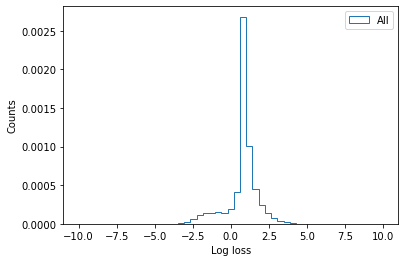

In [48]:
if evaluate_signals:
    plt.hist(sig_output['log_losses'], bins=logloss_bins, label='All', weights=sig_output['weights'],histtype='step')
    plt.xlabel('Log loss')
    plt.ylabel('Counts')
    plt.legend()
    plt.savefig(os.path.join(output_dir, 'Log_Ascore_SignalsAll.png'))
    plt.show()

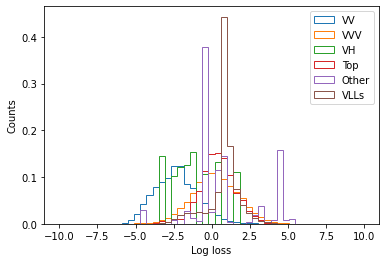

In [49]:
num_bins = 10
fig = plt.figure()

for group, samples in groupings.items():
    bar_heights = 0
    index = np.where(np.isin(test_output['samples'],samples))
    weights = np.array(test_output['weights'])[index] / np.sum(np.array(test_output['weights'])[index])
    plt.hist(np.array(test_output['log_losses'])[index], bins=logloss_bins, label=group, weights=weights,histtype='step')
    
if evaluate_signals:
    weights2 = np.array(sig_output['weights']) / np.sum(np.array(sig_output['weights']))
    plt.hist(sig_output['log_losses'], bins=logloss_bins, label='VLLs', weights=weights2,histtype='step')
    
plt.xlabel('Log loss')
plt.ylabel('Counts')
plt.legend()
plt.savefig(os.path.join(output_dir, 'Anomaly_score_hist_bySampleNormalised_VLL.png'))
plt.show()

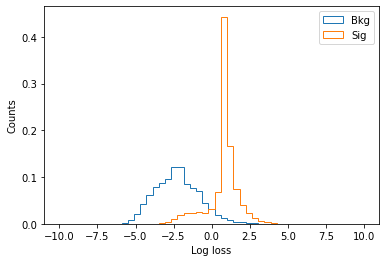

In [50]:
num_bins = 50
plt.hist(test_output['log_losses'], bins=logloss_bins, label='Bkg', weights=test_output['weights']/np.sum(test_output['weights']),histtype='step')
if evaluate_signals:
    plt.hist(sig_output['log_losses'], bins=logloss_bins, label='Sig', weights=sig_output['weights']/np.sum(sig_output['weights']),histtype='step')
plt.xlabel('Log loss')
plt.ylabel('Counts')
plt.legend()
plt.savefig(os.path.join(output_dir, 'Log_Ascore_BkgvsSig_50bins.png'))
plt.show()

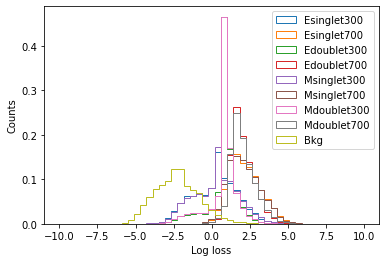

In [51]:
if evaluate_signals:
    num_bins = 50
    for sample in signal_sample_types:
        index = np.where(np.isin(sig_output['samples'],[sample]))
        weights = np.array(sig_output['weights'])[index] / np.sum(np.array(sig_output['weights'])[index])
        plt.hist(np.array(sig_output['log_losses'])[index], bins=logloss_bins, label=sample, weights=weights,histtype='step')
    
    weights2 = np.array(test_output['weights']) / np.sum(np.array(test_output['weights']))
    plt.hist(test_output['log_losses'], bins=logloss_bins, label='Bkg', weights=weights2,histtype='step')
    plt.xlabel('Log loss')
    plt.ylabel('Counts')
    plt.legend()
    plt.savefig(os.path.join(output_dir, 'SignalSample_breakdown.png'))
    plt.show()

/tmp/ipykernel_626/1317226841.py:5: RuntimeWarning: invalid value encountered in true_divide
  ch2 = np.nan_to_num(((x-y)**2)/(x+y), copy=True, nan=0.0, posinf=None, neginf=None)


Histogram: Esinglet300, chi2 distance from background: 0.4459568007710004
Histogram: Mdoublet700, chi2 distance from background: 0.9195064061886162


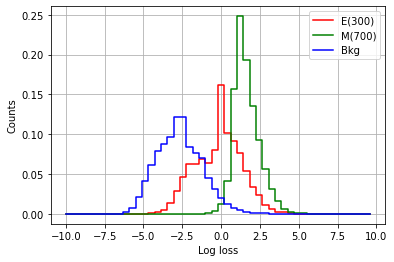

In [52]:
# Calculate a low mass and a high mass separation

def get_chi2distance(x,y):
    
    ch2 = np.nan_to_num(((x-y)**2)/(x+y), copy=True, nan=0.0, posinf=None, neginf=None)
    ch2 = 0.5 * np.sum(ch2)
    return ch2


separation_samples = ['Esinglet300', 'Mdoublet700']

if evaluate_signals:
    
    histos = []
    edges = []
    test_logloss_counts, test_logloss_edges = np.histogram(test_output['log_losses'], bins=logloss_bins, weights=test_output['weights']/np.sum(test_output['weights']))
    
    for sample in separation_samples:
        index = np.where(np.isin(sig_output['samples'],[sample]))
        weights = np.array(sig_output['weights'])[index] /  np.sum(np.array(sig_output['weights'])[index])
        loss_counts, loss_edges = np.histogram(sig_output['log_losses'][index], bins=logloss_bins, weights=weights)
        histos.append(loss_counts)
        edges.append(loss_edges)

    
    chi2_out = []
    for i, sample in enumerate(separation_samples):
        chi2 = get_chi2distance(test_logloss_counts, histos[i])
        out_str = f"Histogram: {sample}, chi2 distance from background: {chi2}"
        print(out_str)
        chi2_out.append(out_str + '\n')
    histos.append(test_logloss_counts)
    edges.append(test_logloss_edges)
    with open(os.path.join(output_dir, 'Chi2_Distances.txt'),'w') as f:
        f.writelines(chi2_out)
        
    savename = os.path.join(output_dir, 'Separation_Hist.png')
    fig = plot_hist_stack(edges, histos, xlabel='Log loss', colours=['r','g','b'], ylabel='Counts', labels=['E(300)','M(700)','Bkg'], save_name=savename)

IndexError: list index out of range

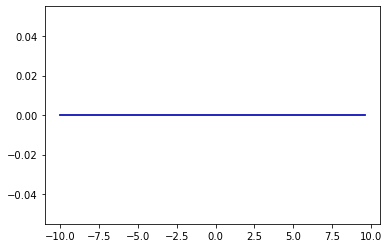

In [56]:
#Plot by VLL_type
if evaluate_signals:
    
    histos = []
    edges = []
    types = []
    
    #ONLY PLOT E(300)
        
    for vll_type in set(sig_output['vll_type']):
        index1 = np.where(np.isin(sig_output['samples'],[separation_samples[0]]))
        index2 = np.where(np.isin(np.array(sig_output['vll_type'])[index1],[vll_type]))
        sum_W = np.sum(np.array(sig_output['weights'])[index1][index2])
        if sum_W == 0:
            weights=np.zeros(shape=np.array(sig_output['weights'])[index1][index2].shape)
        else:
            weights = np.array(sig_output['weights'])[index1][index2] /  sum_W
        loss_counts, loss_edges = np.histogram(sig_output['log_losses'][index1][index2], bins=logloss_bins, weights=weights)
        histos.append(loss_counts)
        edges.append(loss_edges)
        types.append(vll_type)
        
    histos.append(test_logloss_counts)
    edges.append(test_logloss_edges)
    
    savename = os.path.join(output_dir, 'VLL_type_breakdown.png')
    fig = plot_hist_stack(edges, histos, xlabel='Log loss', colours=['r','g','y','b'], ylabel='Counts', labels=['LL','NL','NN','Bkg'], save_name=savename)
        
        

In [ ]:
#Plot by VLL_decaytype
if evaluate_signals:
    
    histos = []
    edges = []
    types = []
        
    for vll_decaytype in set(sig_output['vll_decaytype']):
        
        index1 = np.where(np.isin(sig_output['samples'],[separation_samples[0]]))
        index2 = np.where(np.isin(np.array(sig_output['vll_decaytype'])[index1],[vll_decaytype]))
        weights = np.array(sig_output['weights'])[index1][index2] /  np.sum(np.array(sig_output['weights'])[index1][index2])
        loss_counts, loss_edges = np.histogram(sig_output['log_losses'][index1][index2], bins=logloss_bins, weights=weights)
        histos.append(loss_counts)
        edges.append(loss_edges)
        types.append(vll_decaytype)
        
    histos.append(test_logloss_counts)
    edges.append(test_logloss_edges)
    
    savename = os.path.join(output_dir, 'VLL_decaytype.png')
    fig = plot_hist_stack(edges, histos, xlabel='Log loss', colours=['r','g','y','c','m','k','b'], ylabel='Counts', labels=['ZZ','HH','WW','HZ','WZ','WH','Bkg'], save_name=savename)
        

In [ ]:
mu_0 = [m[0][0] for m in test_output['mu']]
mu_1 = [m[0][1] for m in test_output['mu']]
sig_mu0 = [m[0][0] for m in sig_output['mu']]
sig_mu1 = [m[0][1] for m in sig_output['mu']]

plt.scatter(sig_mu0, sig_mu1, label='Sig')
plt.scatter(mu_0, mu_1, label='Bkg')

plt.xlabel('z1')
plt.ylabel('z2')
plt.legend()
plt.savefig(os.path.join(output_dir, 'LatentScatter_SigvsBkg.png'))
plt.show()